In [2]:
from google.colab import drive
drive.mount('/content/drive') #挂载云盘

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('drive/My Drive/Colab/image')

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
from tqdm import tqdm_notebook

# Load Data / show sample / prepare features

- load data 

In [7]:
trnImages = np.load('trnImage.npy')
tstImages = np.load('tstImage.npy')
trnLabels = np.load('trnLabel.npy')
tstLabels = np.load('tstLabel.npy')

In [8]:
trnLabels=trnLabels.ravel()
tstLabels=tstLabels.ravel()

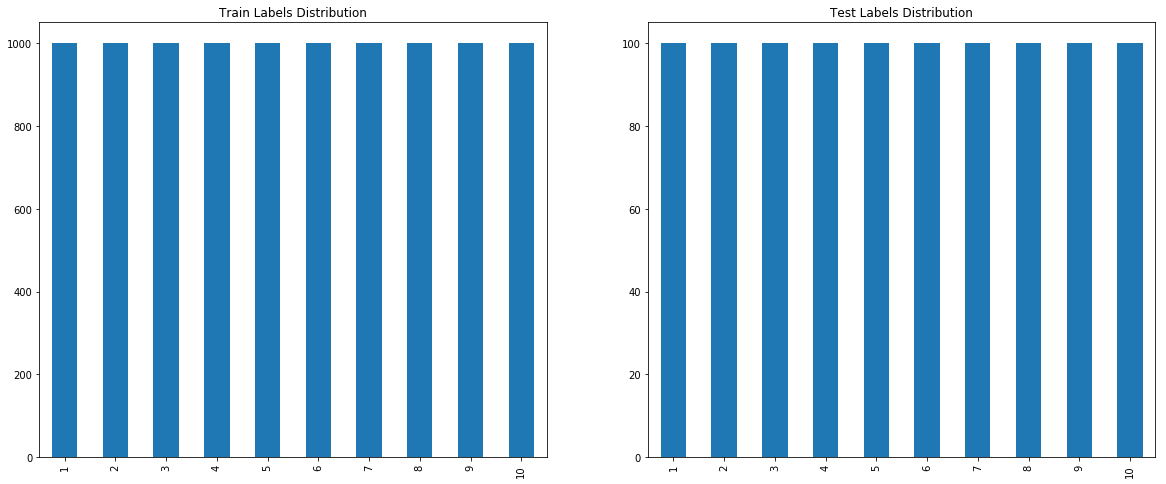

In [34]:
# 训练/测试标签分布
import pandas as pd

fig,axes=plt.subplots(1,2,figsize=(20,8))

pd.Series(trnLabels).value_counts().sort_index().plot(kind='bar',ax=axes[0],
                                        title='Train Labels Distribution')

pd.Series(tstLabels).value_counts().sort_index().plot(kind='bar',ax=axes[1],
                                        title='Test Labels Distribution')
plt.show()

- show sample

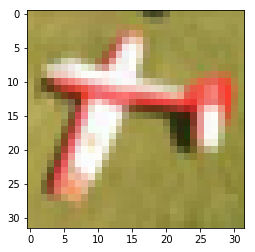

In [11]:
trnidx = 20
plt.imshow(trnImages[:,:,:,trnidx])

- prepare features

In [9]:
def computeFeatures(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features as hog_feature. 
    # By setting visualize=True we obtain an image, hog_as_image, which can be plotted for insight into extracted HOG features.
    hog_feature, hog_as_image = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return hog_feature, hog_as_image

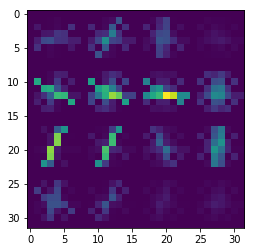

In [12]:
# Extract the features from a single image
features, hog_image = computeFeatures(trnImages[:,:,:,trnidx])

plt.imshow(hog_image)
plt.show(block=False)

In [13]:
trn_num,tst_num=trnImages.shape[3],tstImages.shape[3]


trnFeatures,tstFeatures=[],[]
# trnFeatures generating
for i in tqdm_notebook(range(trn_num),desc='trnFeatures generating'):
    this_feature,_=computeFeatures(trnImages[:,:,:,i])
    trnFeatures.append(this_feature)
    
# tstFeatures generating
for i in tqdm_notebook(range(tst_num),desc='tstFeatures generating'):
    this_feature,_=computeFeatures(tstImages[:,:,:,i])
    tstFeatures.append(this_feature)

In [0]:
trnFeatures=np.vstack(trnFeatures)
tstFeatures=np.vstack(tstFeatures)
trnFeatures.shape,tstFeatures.shape

((10000, 324), (1000, 324))

In [19]:
# maybe standarlize data better?
from sklearn.preprocessing import StandardScaler
SCALE=StandardScaler()

trnFeatures_scale=SCALE.fit_transform(trnFeatures)
tstFeatures_scale=SCALE.fit_transform(tstFeatures)

# Model

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier

def display_confusion_matrix(confusion_mat):
    '''display confusion_matrix'''
    print(confusion_mat)
    plt.imshow(confusion_mat,cmap=plt.cm.rainbow)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(range(10));plt.yticks(range(10))
    plt.ylabel('True Label');plt.xlabel('Predicted Label')
    plt.show()

In [36]:
a1=pd.DataFrame([[1,2],[11,22]])


### 1. svm

In [15]:
svm_clf=SVC(max_iter=10000)

- un-StandardScale feature

In [16]:
svm_clf.fit(trnFeatures,trnLabels)
label_pred_11=svm_clf.predict(tstFeatures)

/Users/is_bada/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[28 11  9  0  8  2  7  0 33  2]
 [ 1 50  0  1  4  2 11  0 24  7]
 [ 6  5 18  5  3 29 24  1  6  3]
 [ 0  6  7 27  4 20 29  2  2  3]
 [ 4 11  1 19 34  7 18  0  4  2]
 [ 0  3  6 12  5 58 15  0  1  0]
 [ 2  7  8  7  3  9 62  1  1  0]
 [ 0  3  4 10 22 19  6 28  4  4]
 [ 7 15  4  1  0  1  4  0 61  7]
 [ 0 15  0  4  5  2  5  2 13 54]]


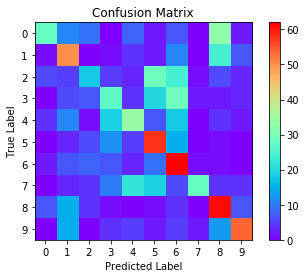

              precision    recall  f1-score   support

           1       0.28      0.58      0.38        48
           2       0.50      0.40      0.44       126
           3       0.18      0.32      0.23        57
           4       0.27      0.31      0.29        86
           5       0.34      0.39      0.36        88
           6       0.58      0.39      0.47       149
           7       0.62      0.34      0.44       181
           8       0.28      0.82      0.42        34
           9       0.61      0.41      0.49       149
          10       0.54      0.66      0.59        82

    accuracy                           0.42      1000
   macro avg       0.42      0.46      0.41      1000
weighted avg       0.48      0.42      0.43      1000



In [17]:
# confusion_matrix and visualization
confusion_matrix_11=confusion_matrix(tstLabels,label_pred_11)
display_confusion_matrix(confusion_matrix_11)
print(classification_report(label_pred_11,tstLabels))

- StandardScale feature

In [20]:
svm_clf.fit(trnFeatures_scale,trnLabels)
label_pred_12=svm_clf.predict(tstFeatures_scale)

[[68  2  6  2  3  1  2  5 10  1]
 [ 4 64  0  2  4  1  3  3 11  8]
 [ 6  1 49  5  7 16  8  4  2  2]
 [ 2  3 14 41 12 11  9  4  1  3]
 [ 4  2  7 11 63  4  6  1  2  0]
 [ 1  1  6 10  8 58  7  7  1  1]
 [ 1  4  7  6  8  9 63  1  1  0]
 [ 2  0  6  8 10  8  3 58  1  4]
 [ 9 11  4  2  1  0  1  0 69  3]
 [ 6  6  0  5  3  3  0  3  9 65]]


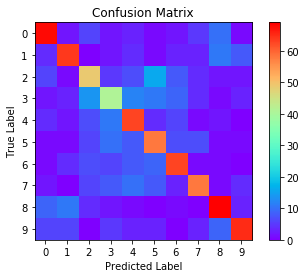

              precision    recall  f1-score   support

           1       0.68      0.66      0.67       103
           2       0.64      0.68      0.66        94
           3       0.49      0.49      0.49        99
           4       0.41      0.45      0.43        92
           5       0.63      0.53      0.58       119
           6       0.58      0.52      0.55       111
           7       0.63      0.62      0.62       102
           8       0.58      0.67      0.62        86
           9       0.69      0.64      0.67       107
          10       0.65      0.75      0.70        87

    accuracy                           0.60      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg       0.60      0.60      0.60      1000



In [21]:
# confusion_matrix and visualization
confusion_matrix_12=confusion_matrix(tstLabels,label_pred_12)
display_confusion_matrix(confusion_matrix_12)
print(classification_report(label_pred_12,tstLabels))

### 2. Kmeans

In [0]:
kmean_clf=KMeans(n_clusters=10,random_state=1)

- un-StandardScale feature

In [0]:
kmean_clf.fit(trnFeatures,trnLabels)
label_pred_21=kmean_clf.predict(tstFeatures)

[[ 0  0  0  0  0  0  0  0  0  0  0]
 [24  4  1  4 14 15 11  2 19  6  0]
 [23  5  3  9  2 21  9  5 21  2  0]
 [ 1  6 24  8 16  5  5  5  7 23  0]
 [ 0 12 32  5  8  2  5 22  2 12  0]
 [ 3 16 19 17  7  5  5 13  5 10  0]
 [ 1  5 54  6  5  2  0 18  0  9  0]
 [ 0  2  9  3 22  5  1 29  6 23  0]
 [ 1 27 18 29  6  0  4 10  0  5  0]
 [35  3  1  1  2  9 31  1 15  2  0]
 [12 27  3 21  2  8 17  4  3  3  0]]


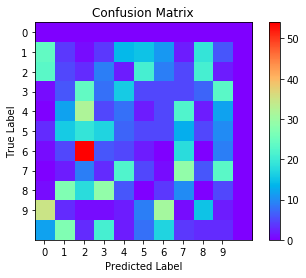

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.04      0.04      0.04       107
           2       0.03      0.02      0.02       164
           3       0.08      0.08      0.08       103
           4       0.08      0.10      0.09        84
           5       0.05      0.07      0.06        72
           6       0.00      0.00      0.00        88
           7       0.29      0.27      0.28       109
           8       0.00      0.00      0.00        78
           9       0.02      0.02      0.02        95
          10       0.00      0.00      0.00         0

    accuracy                           0.06      1000
   macro avg       0.05      0.05      0.05      1000
weighted avg       0.06      0.06      0.06      1000



/Users/is_bada/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/is_bada/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
# confusion_matrix and visualization
confusion_matrix_21=confusion_matrix(tstLabels,label_pred_21)
display_confusion_matrix(confusion_matrix_21)
print(classification_report(label_pred_21,tstLabels))

- StandardScale feature

In [0]:
kmean_clf.fit(trnFeatures_scale,trnLabels)
label_pred_22=kmean_clf.predict(tstFeatures_scale)

[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 5  1  7 16  3 14 17  6 29  2  0]
 [ 8  3 11 21  5  3 23  1 20  5  0]
 [ 9 20  6  5  9 16  4 21  1  9  0]
 [ 5 30  6  1 15  7  2 11  0 23  0]
 [19 14  5  5 17  6  5 10  3 16  0]
 [ 6 52  0  0  7  4  2  8  1 20  0]
 [ 5  8  1  7  2 18  5 23  0 31  0]
 [32 16  4  1 30  4  0  5  1  7  0]
 [ 1  1 28 15  2  3  8  2 38  2  0]
 [19  4 18  4 25  1  9  3 11  6  0]]


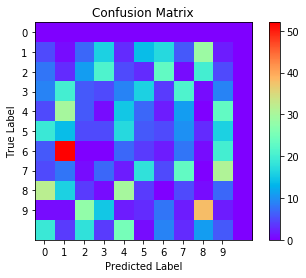

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.01      0.01      0.01       149
           2       0.11      0.13      0.12        86
           3       0.05      0.07      0.06        75
           4       0.15      0.13      0.14       115
           5       0.06      0.08      0.07        76
           6       0.02      0.03      0.02        75
           7       0.23      0.26      0.24        90
           8       0.01      0.01      0.01       104
           9       0.02      0.02      0.02       121
          10       0.00      0.00      0.00         0

    accuracy                           0.07      1000
   macro avg       0.06      0.07      0.06      1000
weighted avg       0.06      0.07      0.06      1000



In [0]:
# confusion_matrix and visualization
confusion_matrix_22=confusion_matrix(tstLabels,label_pred_22)
display_confusion_matrix(confusion_matrix_22)
print(classification_report(label_pred_22,tstLabels))

### 3. Gaussian Mixture Model

In [0]:
gaussian_mix_clf=GaussianMixture(n_components=10)

- un-StandardScale feature

In [0]:
gaussian_mix_clf.fit(trnFeatures,trnLabels)
label_pred_31=gaussian_mix_clf.predict(tstFeatures)

[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 1  4  7  7 44 21  3  7  3  3  0]
 [ 1  1 10 10 45 22  0  4  2  5  0]
 [ 6 17  2 12 34 19  6  1  3  0  0]
 [ 2 24  0 24 31 15  0  0  3  1  0]
 [ 0 11  0 16 56 13  1  0  3  0  0]
 [ 0 30  1 15 43  9  0  0  2  0  0]
 [ 4 10  2 15 54  9  3  0  1  2  0]
 [ 1  8  1 18 43 15  1  0 13  0  0]
 [ 3  1 14  3 33 25  1 15  1  4  0]
 [ 2  1  3  3 50 34  0  3  3  1  0]]


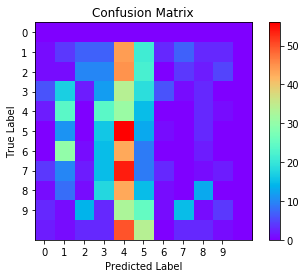

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.04      0.04      0.04       107
           2       0.10      0.25      0.14        40
           3       0.12      0.10      0.11       123
           4       0.31      0.07      0.12       433
           5       0.13      0.07      0.09       182
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        30
           8       0.13      0.38      0.19        34
           9       0.04      0.25      0.07        16
          10       0.00      0.00      0.00         0

    accuracy                           0.09      1000
   macro avg       0.08      0.11      0.07      1000
weighted avg       0.19      0.09      0.10      1000



In [0]:
# confusion_matrix and visualization
confusion_matrix_31=confusion_matrix(tstLabels,label_pred_31)
display_confusion_matrix(confusion_matrix_31)
print(classification_report(label_pred_31,tstLabels))

- StandardScale feature

In [0]:
gaussian_mix_clf.fit(trnFeatures_scale,trnLabels)
label_pred_32=gaussian_mix_clf.predict(tstFeatures_scale)

[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0 26 19 27  3  4  5 10  2  0]
 [ 3  2 34 17 30  3  5  1  5  0  0]
 [ 1  8 14  4 26  5 12 18  6  6  0]
 [ 5  3 20  1 17  0 19 25 10  0  0]
 [ 6  1 17  2 27  1 13 19  9  5  0]
 [ 1  1  7  1 21  1 17 36 11  4  0]
 [ 4  4  8  2 32  3 16 11 17  3  0]
 [ 9  1 25  0 23  1  6 18 16  1  0]
 [ 0  4 32 28 20  9  2  0  2  3  0]
 [ 2  2 46  7 31  0  2  3  3  4  0]]


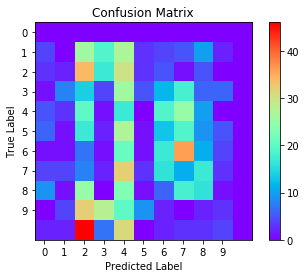

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.00      0.00      0.00        26
           2       0.34      0.15      0.21       229
           3       0.04      0.05      0.04        81
           4       0.17      0.07      0.10       254
           5       0.01      0.04      0.02        26
           6       0.17      0.18      0.17        96
           7       0.11      0.08      0.09       136
           8       0.16      0.18      0.17        89
           9       0.03      0.11      0.05        28
          10       0.00      0.00      0.00         0

    accuracy                           0.10      1000
   macro avg       0.09      0.08      0.08      1000
weighted avg       0.17      0.10      0.12      1000



/Users/is_bada/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/is_bada/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
# confusion_matrix and visualization
confusion_matrix_32=confusion_matrix(tstLabels,label_pred_32)
display_confusion_matrix(confusion_matrix_32)
print(classification_report(label_pred_32,tstLabels))

### 4.  Neural Networks

In [0]:
nn_clf=MLPClassifier(verbose=1)

- un-StandardScale feature

In [0]:
nn_clf.fit(trnFeatures,trnLabels)
label_pred_41=nn_clf.predict(tstFeatures)

Iteration 1, loss = 2.14604725
Iteration 2, loss = 1.83565801
Iteration 3, loss = 1.67242413
Iteration 4, loss = 1.58787662
Iteration 5, loss = 1.54051936
Iteration 6, loss = 1.50101209
Iteration 7, loss = 1.47451811
Iteration 8, loss = 1.45407109
Iteration 9, loss = 1.43293686
Iteration 10, loss = 1.41361332
Iteration 11, loss = 1.40052961
Iteration 12, loss = 1.38360140
Iteration 13, loss = 1.36981483
Iteration 14, loss = 1.35582146
Iteration 15, loss = 1.34145619
Iteration 16, loss = 1.33030209
Iteration 17, loss = 1.31966211
Iteration 18, loss = 1.31007533
Iteration 19, loss = 1.29789212
Iteration 20, loss = 1.29179422
Iteration 21, loss = 1.27875278
Iteration 22, loss = 1.27039614
Iteration 23, loss = 1.26621406
Iteration 24, loss = 1.25729704
Iteration 25, loss = 1.24833423
Iteration 26, loss = 1.23905587
Iteration 27, loss = 1.23418589
Iteration 28, loss = 1.22438220
Iteration 29, loss = 1.21847472
Iteration 30, loss = 1.21160840
Iteration 31, loss = 1.20485251
Iteration 32, los

/Users/is_bada/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[[57  3  8  7  2  1  2  2 15  3]
 [ 4 61  3  1  2  0  3  3 15  8]
 [ 6  0 46  9  5 18  9  1  4  2]
 [ 4  3 12 34 11 16 12  6  2  0]
 [ 2  1 14 12 51  9  2  2  4  3]
 [ 1  1  8 19  6 46  8  8  2  1]
 [ 1  2  8  9  3  5 66  2  2  2]
 [ 1  0  6  7  7 11  4 56  2  6]
 [ 8  5  3  2  1  0  4  0 72  5]
 [ 3 12  2  2  2  3  0  3  7 66]]


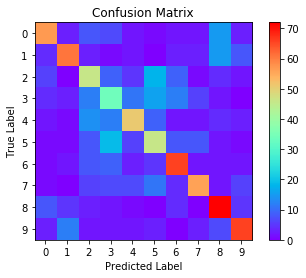

              precision    recall  f1-score   support

           1       0.57      0.66      0.61        87
           2       0.61      0.69      0.65        88
           3       0.46      0.42      0.44       110
           4       0.34      0.33      0.34       102
           5       0.51      0.57      0.54        90
           6       0.46      0.42      0.44       109
           7       0.66      0.60      0.63       110
           8       0.56      0.67      0.61        83
           9       0.72      0.58      0.64       125
          10       0.66      0.69      0.67        96

    accuracy                           0.56      1000
   macro avg       0.55      0.56      0.56      1000
weighted avg       0.56      0.56      0.55      1000



In [0]:
# confusion_matrix and visualization
confusion_matrix_41=confusion_matrix(tstLabels,label_pred_41)
display_confusion_matrix(confusion_matrix_41)
print(classification_report(label_pred_41,tstLabels))

- StandardScale feature

In [0]:
nn_clf.fit(trnFeatures_scale,trnLabels)
label_pred_42=nn_clf.predict(tstFeatures_scale)

Iteration 1, loss = 1.88739365
Iteration 2, loss = 1.41950360
Iteration 3, loss = 1.28255573
Iteration 4, loss = 1.19583355
Iteration 5, loss = 1.13179145
Iteration 6, loss = 1.07418732
Iteration 7, loss = 1.02460740
Iteration 8, loss = 0.98196036
Iteration 9, loss = 0.94485739
Iteration 10, loss = 0.90724971
Iteration 11, loss = 0.87425223
Iteration 12, loss = 0.84398674
Iteration 13, loss = 0.81642207
Iteration 14, loss = 0.79111806
Iteration 15, loss = 0.76410690
Iteration 16, loss = 0.73602408
Iteration 17, loss = 0.71181422
Iteration 18, loss = 0.69063703
Iteration 19, loss = 0.66737807
Iteration 20, loss = 0.64799791
Iteration 21, loss = 0.62722396
Iteration 22, loss = 0.60496924
Iteration 23, loss = 0.58987504
Iteration 24, loss = 0.57006155
Iteration 25, loss = 0.55387323
Iteration 26, loss = 0.53536654
Iteration 27, loss = 0.51716188
Iteration 28, loss = 0.49965510
Iteration 29, loss = 0.48751563
Iteration 30, loss = 0.47204636
Iteration 31, loss = 0.45998505
Iteration 32, los

[[62  3  3  4  3  4  3  5 12  1]
 [ 5 53  5  1  5  3  4  2 12 10]
 [10  0 40 12  7 10  9  3  7  2]
 [ 6  2 11 26 15 20 10  5  2  3]
 [ 4  3 12  9 47  7  6  8  2  2]
 [ 1  2 12 15  9 40  6  8  3  4]
 [ 3  3  6  8 11 10 53  2  2  2]
 [ 2  2  7 10 16  6  2 50  1  4]
 [14 15  5  3  0  0  3  1 50  9]
 [ 6  8  3  2  4  1  0  4  8 64]]


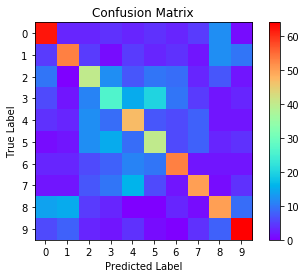

              precision    recall  f1-score   support

           1       0.62      0.55      0.58       113
           2       0.53      0.58      0.55        91
           3       0.40      0.38      0.39       104
           4       0.26      0.29      0.27        90
           5       0.47      0.40      0.43       117
           6       0.40      0.40      0.40       101
           7       0.53      0.55      0.54        96
           8       0.50      0.57      0.53        88
           9       0.50      0.51      0.50        99
          10       0.64      0.63      0.64       101

    accuracy                           0.48      1000
   macro avg       0.48      0.49      0.48      1000
weighted avg       0.49      0.48      0.49      1000



In [0]:
# confusion_matrix and visualization
confusion_matrix_42=confusion_matrix(tstLabels,label_pred_42)
display_confusion_matrix(confusion_matrix_42)
print(classification_report(label_pred_42,tstLabels))

### 5.  Neural Networks( Transfer Learning )

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models , transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import copy
import time



# 指定GPU/CPU参数
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('DEVICE:', device)

DEVICE: cuda:0


In [0]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


class MyDataset(Dataset):
    def __init__(self,X,y):
        self.X=X
        self.y=y
       
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image_arr=self.X[:,:,:,idx]
        feature=transform(image_arr).float()
        label=torch.tensor(self.y[idx]).long()
        return feature, label
    
trn_dataset=MyDataset(trnImages,trnLabels-1)
trn_dataloader=DataLoader(trn_dataset,batch_size=50,shuffle=True,num_workers=4)
tst_dataset=MyDataset(tstImages,tstLabels-1)
tst_dataloader=DataLoader(tst_dataset,batch_size=50,shuffle=True,num_workers=4)

In [0]:
def train_eval_model(model, criterion, optimizer,  num_epochs=25):

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # train model
        model.train()
        running_loss = 0.0
        train_pred,train_true=[],[]
        for inputs, labels in tqdm_notebook(trn_dataloader):
            inputs,labels=inputs.to(device),labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(inputs) 
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            train_pred.extend(preds.tolist())
            train_true.extend(labels.tolist())
        
        train_loss=running_loss/len(trn_dataset)
        train_acc=accuracy_score(train_true,train_pred)
        
        
        
        # eval model
        model.eval()
        test_pred,test_true=[],[]
        with torch.no_grad():
            for inputs, labels in tqdm_notebook(tst_dataloader):
                inputs,labels=inputs.to(device),labels.to(device)
                outputs = model(inputs) 
                _, preds = torch.max(outputs, 1)
                test_pred.extend(preds.tolist())
                test_true.extend(labels.tolist())
        
        test_acc=accuracy_score(test_true,test_pred)
        
        
        print('Loss: {:.4f},Train Acc: {:.4f}, Test Acc: {:.4f}'.format(
                train_loss, train_acc, test_acc))
        
        if test_acc>best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
        

        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [37]:
model_ft = models.resnet18(pretrained=False)
num_ftrs=model_ft.fc.in_features
model_ft.fc=nn.Linear(num_ftrs,10)

model_ft=model_ft.to(device)
criterion=nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft=optim.Adam(model_ft.parameters(),lr=0.01)

model=train_eval_model(model_ft, criterion, optimizer_ft, num_epochs=30)

Epoch 0/29
----------


Loss: 2.1810,Train Acc: 0.2561, Test Acc: 0.2520
Epoch 1/29
----------


Loss: 1.7528,Train Acc: 0.3592, Test Acc: 0.3750
Epoch 2/29
----------


Loss: 1.5384,Train Acc: 0.4374, Test Acc: 0.4310
Epoch 3/29
----------


Loss: 1.4224,Train Acc: 0.4795, Test Acc: 0.4950
Epoch 4/29
----------


Loss: 1.2872,Train Acc: 0.5288, Test Acc: 0.4930
Epoch 5/29
----------


Loss: 1.1742,Train Acc: 0.5794, Test Acc: 0.5730
Epoch 6/29
----------


Loss: 1.0575,Train Acc: 0.6300, Test Acc: 0.5830
Epoch 7/29
----------


Loss: 0.9404,Train Acc: 0.6667, Test Acc: 0.6040
Epoch 8/29
----------


Loss: 0.8242,Train Acc: 0.7079, Test Acc: 0.6220
Epoch 9/29
----------


Loss: 0.7211,Train Acc: 0.7484, Test Acc: 0.6050
Epoch 10/29
----------


Loss: 0.6174,Train Acc: 0.7887, Test Acc: 0.6070
Epoch 11/29
----------


Loss: 0.5038,Train Acc: 0.8268, Test Acc: 0.5850
Epoch 12/29
----------


Loss: 0.4175,Train Acc: 0.8577, Test Acc: 0.6420
Epoch 13/29
----------


Loss: 0.3404,Train Acc: 0.8808, Test Acc: 0.6120
Epoch 14/29
----------


Loss: 0.2743,Train Acc: 0.9043, Test Acc: 0.6280
Epoch 15/29
----------


Loss: 0.2483,Train Acc: 0.9143, Test Acc: 0.6210
Epoch 16/29
----------


Loss: 0.1960,Train Acc: 0.9337, Test Acc: 0.6200
Epoch 17/29
----------


Loss: 0.1686,Train Acc: 0.9434, Test Acc: 0.6290
Epoch 18/29
----------


Loss: 0.1590,Train Acc: 0.9433, Test Acc: 0.6470
Epoch 19/29
----------


Loss: 0.1387,Train Acc: 0.9542, Test Acc: 0.6400
Epoch 20/29
----------


Loss: 0.1238,Train Acc: 0.9574, Test Acc: 0.6210
Epoch 21/29
----------


Loss: 0.1018,Train Acc: 0.9661, Test Acc: 0.6200
Epoch 22/29
----------


Loss: 0.1172,Train Acc: 0.9607, Test Acc: 0.6280
Epoch 23/29
----------


Loss: 0.1086,Train Acc: 0.9637, Test Acc: 0.6350
Epoch 24/29
----------


Loss: 0.0927,Train Acc: 0.9693, Test Acc: 0.6220
Epoch 25/29
----------


Loss: 0.1075,Train Acc: 0.9642, Test Acc: 0.6100
Epoch 26/29
----------


Loss: 0.1025,Train Acc: 0.9639, Test Acc: 0.6400
Epoch 27/29
----------


Loss: 0.1053,Train Acc: 0.9664, Test Acc: 0.6130
Epoch 28/29
----------


Loss: 0.0617,Train Acc: 0.9797, Test Acc: 0.6360
Epoch 29/29
----------


Loss: 0.0550,Train Acc: 0.9828, Test Acc: 0.6270
Training complete in 3m 34s
Best Test Acc: 0.647000


[[67  2  3  3  9  4  1  3  6  2]
 [ 2 73  3  2  2  1  1  3  4  9]
 [ 7  0 43  9 16 12  4  7  1  1]
 [ 3  0  2 40  9 23 12  8  1  2]
 [ 4  0  3  7 75  1  4  4  0  2]
 [ 1  0  2 13  4 64  6  6  3  1]
 [ 0  0  5  5  7  6 73  2  1  1]
 [ 0  1  2  8 10  8  1 70  0  0]
 [ 9  3  1  1  4  2  1  1 78  0]
 [ 6 12  1  4  3  0  2  3  5 64]]


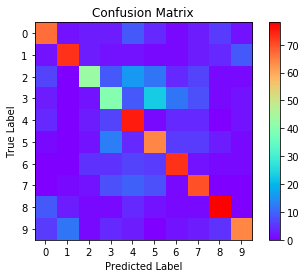

              precision    recall  f1-score   support

           0       0.68      0.67      0.67       100
           1       0.80      0.73      0.76       100
           2       0.66      0.43      0.52       100
           3       0.43      0.40      0.42       100
           4       0.54      0.75      0.63       100
           5       0.53      0.64      0.58       100
           6       0.70      0.73      0.71       100
           7       0.65      0.70      0.68       100
           8       0.79      0.78      0.78       100
           9       0.78      0.64      0.70       100

    accuracy                           0.65      1000
   macro avg       0.66      0.65      0.65      1000
weighted avg       0.66      0.65      0.65      1000



In [40]:
test_pred,test_true=[],[]
with torch.no_grad():
    for inputs, labels in tqdm_notebook(tst_dataloader):
        inputs,labels=inputs.to(device),labels.to(device)
        outputs = model(inputs) 
        _, preds = torch.max(outputs, 1)
        test_pred.extend(preds.tolist())
        test_true.extend(labels.tolist())
        
confusion_matrix_5=confusion_matrix(test_true,test_pred)
display_confusion_matrix(confusion_matrix_5)

print(classification_report(test_true,test_pred))